# Homework 5 : RNN and KMeans (100 points)

*------------


**Required Readings:** 
* [RNN](http://karpathy.github.io/2015/05/21/rnn-effectiveness/), [Keras Code Example](https://github.com/fchollet/keras/blob/master/examples/lstm_text_generation.py)

** NOTE **
* Please don't forget to save the notebook frequently when working in IPython Notebook, otherwise the changes you made can be lost.

*----------------------

# Problem 1 (40 points): Use simple RNN to generate Yelp Reviews

* Load the Yelp reviews in the reviews.json file.
* The code below transforms the text into short sentences.
* Please use SimpleRNN to train on the review data, and genrate at least 5 reviews.
* The speed and performance of the RNN depend on the number of neurons in the hidden layer. The more hidden neurons in the RNN, the slower in speed and the better in performance.

In [4]:
import numpy as np
import random
import sys
import json

# load json file and extract reviews
review_data = []
for line in open('reviews.json', 'r'):
    review_data.append(json.loads(line)['text'])
text= ''.join(review_data)
print('review length:', len(text))


# extract the set of characters
chars = sorted(list(set(text)))
print('nb chars:', len(chars))
# character index
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))


# cut the text in short sequences of (maxlen) characters
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

print('Vectorization...')
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1
print('Done')

('review length:', 635393)
('nb chars:', 92)
('nb sequences:', 211785)
Vectorization...
Done


## build the model

In [11]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers.recurrent import SimpleRNN
from keras.optimizers import RMSprop

hidden_rnn_units = 50
output = X[0].shape[1]
input_shape = X[0].shape

# build the model: a simple RNN
#------------------------------------------
model = Sequential()
model.add(SimpleRNN(hidden_rnn_units, input_shape = input_shape))
model.add(Dense(output))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='sgd')




#------------------------------------------


## train the RNN model and generate reviews

In [13]:
from __future__ import print_function

def sample(preds):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) 
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

#number of iterations in the training
nb_iterations= 10 

# train the model, output generated text after each iteration
for iteration in range(nb_iterations):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model.fit(X, y, batch_size=128, nb_epoch=1)

    start_index = random.randint(0, len(text) - maxlen - 1)
    generated = ''
    sentence = text[start_index: start_index + maxlen]
    generated += sentence
    print('----- Generating with seed: "' + sentence + '"')
    sys.stdout.write(generated)
    for i in range(400):
        x = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(sentence):
            x[0, t, char_indices[char]] = 1.

        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds)
        next_char = indices_char[next_index]
        generated += next_char
        sentence = sentence[1:] + next_char

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()



--------------------------------------------------
Iteration 0
Epoch 1/1
211785/211785 [==============================] - 28s - loss: 3.0245    
----- Generating with seed: "the second one ended sooner.  They need "
the second one ended sooner.  They need ag  eewhhtklwUm
iekwp onam/inhlo til  ttyh Ioedhv )  rtbt to ue h st eleo"tsd dioIususu'' iuslanp sue s en =ib es n)or s.weao e toyoeailenigSr.c,ev okc aer^hrft o6knnu uh olhs tbhaIsnhtd i avtoe anubtepseuotat .d lgdn /deen nhte we cphietoo r oerestayb yeet tetnn roodgaahe ewMhwtn0 oeo]mot Cayad gl focw .n.r uete o7ehva go  tssc oMet go   bktudt,yrees aso pemss yeponssa  eod a.et.,eoup,  noI epagl

--------------------------------------------------
Iteration 1
Epoch 1/1
211785/211785 [==============================] - 27s - loss: 2.9474    
----- Generating with seed: " strip mall may be changed.  That would "
 strip mall may be changed.  That would s mlelait ybsthtgkonrtee th  owmol taey wd.n sd ycaerelka ao rs s lur eeg ek  pse iog

# Problem 2: Implementing k-Means Clustering (60 points)
In this question, please implement the famous $k$-means clustering algorithm. You could use the toy data to test the correctness of your code. We assume $k=3$, i.e., we want to group the data points into 3 clusters.
* Please do NOT use any existing package/function for kmeans clustering algorithm and implement your own version of the kmeans.

Cluster centers I counted:
[array([ 1.07705469, -1.06730994]), array([-1.07159013, -1.00648645]), array([ 0.96700708,  1.01837274])]
Cluster Centers:
[[ 0.96700708  1.01837274]
 [-1.07262225 -1.00554224]
 [ 1.0759079  -1.06824293]]


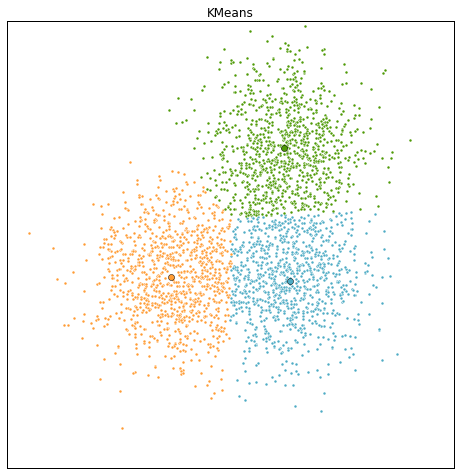

In [3]:
%matplotlib inline

import time
import numpy as np
import matplotlib.pyplot as plt


from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.datasets.samples_generator import make_blobs


#Generate sample data
np.random.seed(0)
batch_size = 45
centers = [[1, 1], [-1, -1], [1, -1]]
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples=3000, centers=centers, cluster_std=0.7)



#Compute clustering with KMeans. 
#---------------------------------------

def nearest(x, centroids):
    """Finds the index of the centroid that is closest to x"""
    dists = list(map(lambda c: np.linalg.norm(x-c), centroids))
    return (np.argmin(dists), min(dists))

i=0
# Randomly select centroids from our input points
centroids = [X[int(np.random.rand()*len(X))] for i in range(n_clusters)]
old_centroids = []
while not np.array_equal(centroids, old_centroids) and i!=100:
    i+= 1 # Just making sure we don't run forever... shouldn't ever happen
    clustered_points = [[] for i in range(n_clusters)]
    for x in X: # For each point, find it's category
        cat, distance = nearest(x, centroids)
        clustered_points[cat].append(x)
    old_centroids = centroids
    centroids = [np.array(points).mean(axis=0) for points in clustered_points ]

print("Cluster centers I counted:")
print(centroids)
k_means_cluster_centers = centroids
# replace this block of code with your implementation of kmeans.
# you could use this code to check the correctness of your result.

from sklearn.cluster import KMeans
k_means = KMeans(n_clusters=3, n_init=10)
k_means.fit(X)
#k_means_cluster_centers = k_means.cluster_centers_
#----------------------------------------

print("Cluster Centers:")
print(k_means.cluster_centers_)


# plot the result
fig = plt.figure(figsize=(8, 8))
colors = ['#4EACC5', '#FF9C34', '#4E9A06']
k_means_labels = pairwise_distances_argmin(X, k_means_cluster_centers)
ax = fig.add_subplot(1, 1, 1)
for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], 'w',
            markerfacecolor=col, marker='.')
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=6)
ax.set_title('KMeans')
ax.set_xticks(())
ax.set_yticks(())
plt.show()

*-----------------
# Done

All set! 

** What do you need to submit?**

* **Notebook File**: Save this IPython notebook, and find the notebook file in your folder (for example, "filename.ipynb"). This is the file you need to submit. Please make sure all the plotted tables and figures are in the notebook. If you used "ipython notebook --pylab=inline" to open the notebook, all the figures and tables should have shown up in the notebook.


** How to submit: **
  Please submit your notebook file through myWPI, in the Assignment "Homework 5".